<a href="https://colab.research.google.com/github/Harshalzzzzzzz/Hand_EMG_classification/blob/main/Multi_subject_Identification_of_Hand_Movements_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand movement classification using EMG signals

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!git clone https://github.com/kymatio/kymatio.git

# go to kymatio folder
%cd kymatio

# use git to download the source
!git pull origin master

# install packages requirements
!pip install -r requirements.txt

# install package
!python setup.py install

Cloning into 'kymatio'...
remote: Enumerating objects: 6030, done.
remote: Counting objects: 100% (789/789), done.
remote: Compressing objects: 100% (475/475), done.
remote: Total 6030 (delta 510), reused 506 (delta 305), pack-reused 5241
Receiving objects: 100% (6030/6030), 2.42 MiB | 10.60 MiB/s, done.
Resolving deltas: 100% (3945/3945), done.
/content/kymatio
From https://github.com/kymatio/kymatio
 * branch            master     -> FETCH_HEAD
Already up to date.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running install
running bdist_egg
running egg_info
creating kymatio.egg-info
writing kymatio.egg-info/PKG-INFO
writing dependency_links to kymatio.egg-info/dependency_links.txt
writing requirements to kymatio.egg-info/requires.txt
writing top-level names to kymatio.egg-info/top_level.txt
writing manifest file 'kymatio.egg-info/SOURCES.txt'
adding license file 'LICENSE.md'
adding license file 'AUTHORS.md'
writing manifest file 

In [ ]:
import os

# Establishing the current work directory (cwd)
thisdir = '/content/drive/My Drive/emg-signal-classification-master/'#/EMG_data_for_gestures-master'
Files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if ".txt" in file:
            Files.append(os.path.join(r, file))
filenames = Files[1:]

## Libraries


In [ ]:
import seaborn as sn; sn.set() 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option

import scipy.signal as signal
from pywt import dwt,Wavelet

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode

from keras.layers import Dense
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
from keras.models import Sequential
import keras.utils
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import keras
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.layers import Dense, Flatten, Conv1D
import kymatio
from scipy.signal import decimate

##  Creating different DataFrames for train, validation and test (raw data)

In [ ]:
filenames

In [ ]:
pd.read_csv(filenames[0], sep='\t')#.drop(columns='time')

In [ ]:
def resp_frec(w,h,fs):
    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')
    
    ax1.plot((w/(np.pi))*(fs/2), 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [Hz]')
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot((w/(np.pi))*(fs/2), angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')

def Data_separation(filename, plot_filter=False, plot_signal=False):
    Data = pd.read_csv(filename, sep="\t")  # Import .txt file with raw data
    Data = Data.drop(columns="time")   # "time" column is removed due to some intervals (few miliseconds) are missing and affect
                                       # DataFrame indexing 

    # fs = 1000                       # Filter design, Bandpass 20-180 Hz
    # ws1, wp1, wp2, ws2 = 1, 20, 180, 200
    # gpass, gstop = 1, 60
    # n, Wn = signal.ellipord([wp1,wp2], [ws1,ws2], gpass, gstop, fs=fs, analog=False)
    # b, a = signal.ellip(n, gpass, gstop, Wn, btype='bandpass', analog=False,  fs=fs)
    # w, h = signal.freqz(b,a)

    # fs = 1000                       # Filter design, Bandpass 10-480 Hz
    # ws1, wp1, wp2, ws2 = 1, 10, 480, 500
    # gpass, gstop = 1, 60
    # n, Wn = signal.ellipord([wp1,wp2], [ws1,ws2], gpass, gstop, fs=fs, analog=False)
    # b, a = signal.ellip(n, gpass, gstop, Wn, btype='bandpass', analog=False,  fs=fs)
    # w, h = signal.freqz(b,a) 

    # fs = 1000                         # Filter design, Highpass 20 Hz
    # gpass, gstop = 1, 60
    # wp, ws = (40)/(fs/2), (20)/(fs/2)
    # N = len(Data['channel1'])
    # f = (fs/2)*np.linspace(0,1,int(N/2))
    # b, a = signal.iirdesign(wp, ws, gpass, gstop, analog=False, ftype='butter')
    # w, h = signal.freqz(b,a)

    if plot_filter: 
      resp_frec(w, h, fs)
      #plt.axvline(wp1, color='r') # Vertical lines at cut-off frequencies
      #plt.axvline(wp2, color='r')
      #plt.axvline(ws1)
      #plt.axvline(ws2)
      plt.show()

    if plot_signal:
      Data['channel1'].plot()
      plt.show()
      Data['channel1'][9000:10000].plot()
      plt.show()

    # Data['channel1']= signal.filtfilt(b,a,Data['channel1']) # Applying the filter
    # Data['channel2']= signal.filtfilt(b,a,Data['channel2'])
    # Data['channel3']= signal.filtfilt(b,a,Data['channel3'])
    # Data['channel4']= signal.filtfilt(b,a,Data['channel4'])
    # Data['channel5']= signal.filtfilt(b,a,Data['channel5'])
    # Data['channel6']= signal.filtfilt(b,a,Data['channel6'])
    # Data['channel7']= signal.filtfilt(b,a,Data['channel7'])
    # Data['channel8']= signal.filtfilt(b,a,Data['channel8']) 

    if plot_signal:
      Data['channel1'].plot()
      plt.show()
      Data['channel1'][9000:10000].plot()
      plt.show()

    g1 = Data[Data['class'] == 1].index.tolist() # Getting the indexes of each gesture 
    g2 = Data[Data['class'] == 2].index.tolist()
    g3 = Data[Data['class'] == 3].index.tolist()
    g4 = Data[Data['class'] == 4].index.tolist()
    g5 = Data[Data['class'] == 5].index.tolist()
    g6 = Data[Data['class'] == 6].index.tolist()
 
    df1 = Data.iloc[g1]  # Creating a new DataFrame for each gesture
    df2 = Data.iloc[g2]
    df3 = Data.iloc[g3]
    df4 = Data.iloc[g4]
    df5 = Data.iloc[g5]
    df6 = Data.iloc[g6]
    return df1,df2,df3,df4,df5,df6

[df1,df2,df3,df4,df5,df6]=Data_separation(filenames[0], plot_filter=False, plot_signal=False)
Gesto1=df1
Gesto2=df2
Gesto3=df3
Gesto4=df4
Gesto5=df5
Gesto6=df6

filenames_train=filenames[1:60]

for i in range(len(filenames_train)):
    [df1,df2,df3,df4,df5,df6]=Data_separation(filenames[i])
    Gesto1=Gesto1.append(df1)
    Gesto2=Gesto2.append(df2)
    Gesto3=Gesto3.append(df3)
    Gesto4=Gesto4.append(df4)
    Gesto5=Gesto5.append(df5)
    Gesto6=Gesto6.append(df6)

Traindata=Gesto1
Traindata=Traindata.append(Gesto2)
Traindata=Traindata.append(Gesto3)
Traindata=Traindata.append(Gesto4)
Traindata=Traindata.append(Gesto5)
Traindata=Traindata.append(Gesto6)       

filenames_valid=filenames[60:66]

[df1,df2,df3,df4,df5,df6]=Data_separation(filenames_valid[0])
Gesto1=df1
Gesto2=df2
Gesto3=df3
Gesto4=df4
Gesto5=df5
Gesto6=df6

for i in range(len(filenames_valid[1:])):
    [df1,df2,df3,df4,df5,df6]=Data_separation(filenames[i])
    Gesto1=Gesto1.append(df1)
    Gesto2=Gesto2.append(df2)
    Gesto3=Gesto3.append(df3)
    Gesto4=Gesto4.append(df4)
    Gesto5=Gesto5.append(df5)
    Gesto6=Gesto6.append(df6)

Validdata=Gesto1
Validdata=Validdata.append(Gesto2)
Validdata=Validdata.append(Gesto3)
Validdata=Validdata.append(Gesto4)
Validdata=Validdata.append(Gesto5)
Validdata=Validdata.append(Gesto6)  

filenames_test=filenames[66:72]

[df1,df2,df3,df4,df5,df6]=Data_separation(filenames_test[0])
Gesto1=df1
Gesto2=df2
Gesto3=df3
Gesto4=df4
Gesto5=df5
Gesto6=df6

for i in range(len(filenames_test[1:])):
    [df1,df2,df3,df4,df5,df6]=Data_separation(filenames[i])
    Gesto1=Gesto1.append(df1)
    Gesto2=Gesto2.append(df2)
    Gesto3=Gesto3.append(df3)
    Gesto4=Gesto4.append(df4)
    Gesto5=Gesto5.append(df5)
    Gesto6=Gesto6.append(df6)

Testdata=Gesto1
Testdata=Testdata.append(Gesto2)
Testdata=Testdata.append(Gesto3)
Testdata=Testdata.append(Gesto4)
Testdata=Testdata.append(Gesto5)
Testdata=Testdata.append(Gesto6)  

## Dividing DataFrames into features and label vectors

In [ ]:
Labels_train = Traindata['class']
Features_train = Traindata[Traindata.columns[0:8]]

Labels_valid = Validdata['class']
Features_valid = Validdata[Validdata.columns[0:8]]

Labels_test = Testdata['class']
Features_test = Testdata[Testdata.columns[0:8]]

In [ ]:
len(Features_train)#+len(Features_test)+len(Features_valid)

## Scaling

In [ ]:
scaler = preprocessing.StandardScaler().fit(Features_train)
Features_train_scaler = scaler.transform(Features_train)
Features_valid_scaler = scaler.transform(Features_valid)
Features_test_scaler = scaler.transform(Features_test)

In [ ]:
len(Scattering_valid)

In [ ]:
kymatio.Scattering1D(2, Features_test.to_numpy()[:,i].shape[0], 8)(Features_test.to_numpy()[:,i]).shape

In [ ]:
decimate(Labels_train, 4).shape

In [ ]:
def downsample(array, factor):
  output = []
  for i in range(0,len(array),factor):
    output.append(array[i])
  return np.array(output).reshape(-1)

In [ ]:
np.array(Labels_train)

In [ ]:
downsample(np.array([1,2,3,4,5,6]),2)

In [ ]:
Scattering_train = []
Scattering_test = []
Scattering_valid = []
for i in range(Features_train.shape[-1]):
  Scattering_train.append(kymatio.Scattering1D(2, Features_train.to_numpy()[:,i].shape[0], 8)(Features_train.to_numpy()[:,i]))
for i in range(Features_test.shape[-1]):
  Scattering_test.append(kymatio.Scattering1D(2, Features_test.to_numpy()[:,i].shape[0], 8)(Features_test.to_numpy()[:,i]))
for i in range(Features_valid.shape[-1]):
  Scattering_valid.append(kymatio.Scattering1D(2, Features_valid.to_numpy()[:,i].shape[0], 8)(Features_valid.to_numpy()[:,i]))
Scattering_train = np.array(Scattering_train).reshape((-1,64))
Scattering_test = np.array(Scattering_test).reshape((-1,64))
Scattering_valid = np.array(Scattering_valid).reshape((-1,64))

Scattering_Labels_train = downsample(np.array(Labels_train), 4)
Scattering_Labels_test = downsample(np.array(Labels_test), 4)
Scattering_Labels_valid = downsample(np.array(Labels_valid), 4)

## Function to print metrics of a model.

In [ ]:
def metrics(Y_validation,predictions):
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creating confussion matrix
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Plotting cofusion matrix
    snn_df_cm = pd.DataFrame(snn_cm, range(6), range(6))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()  

## Tuning KNN model, n_neighbors parameter

In [ ]:
#Testing different values of n_neighbors
limit=6
x=[x for x in range(1,limit)]
yValidation=[0 for x in range(1,limit)]
ytrain=[0 for x in range(1,limit)]
yValidationScaler=[0 for x in range(1,limit)]
ytrainScaler=[0 for x in range(1,limit)]
yValidationPCA=[0 for x in range(1,limit)]
ytrainPCA=[0 for x in range(1,limit)]
yValidationPCAScaler=[0 for x in range(1,limit)]
ytrainPCAScaler=[0 for x in range(1,limit)]
for i in range(1,limit):
    KNN = KNeighborsClassifier(n_neighbors=i)
    
    KNN.fit(Features_train, Labels_train)
    trainScore=KNN.score(Features_train,Labels_train)
    validationScore=KNN.score(Features_valid,Labels_valid)
    
    KNN.fit(Features_train_scaler, Labels_train)
    trainScoreScaler=KNN.score(Features_train_scaler,Labels_train)
    validationScoreScaler=KNN.score(Features_valid_scaler,Labels_valid)
    
    print('n-neighbors value:',i)
    ytrain[i-1]=trainScore   
    yValidation[i-1]=validationScore
    
    ytrainScaler[i-1]=trainScoreScaler   
    yValidationScaler[i-1]=validationScoreScaler

## Plotting n_neighbors vs accuracy

In [ ]:
plt.figure(figsize=(12, 8), dpi=100, facecolor='w', edgecolor='k')
plt.plot(x,ytrain,label='Train')
plt.plot(x,yValidation,label='Validation')
plt.plot(x,ytrainScaler,label='Train-Scaling')
plt.plot(x,yValidationScaler,label='Validation-Scaling')

plt.xlabel('n-neighbors')
plt.ylabel('Accuracy')
plt.title('n-neighbors vs Accuracy')
plt.legend()
plt.xticks(range(1,6))
plt.savefig('KNN-Algorithm.pdf', dpi=300)
plt.show()  
print('The best score with data validation: ', max(yValidation),'with Neighbors: ',x[yValidation.index(max(yValidation))])
print('The best score with data validation with Scaling: ', max(yValidationScaler),'with Neighbors: ',x[yValidationScaler.index(max(yValidationScaler))])

## KNN model with best n_neighbors value

In [ ]:
Features_train_valid = np.concatenate((Features_train, Features_valid), axis=0)
Labels_train_valid = np.concatenate((Labels_train, Labels_valid), axis=0)

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=x[yValidation.index(max(yValidation))])
KNN.fit(Features_train_valid, Labels_train_valid)
predictions = KNN.predict(Features_test)
metrics(Labels_test,predictions)

In [ ]:
Scattering_valid.shape

In [ ]:
Scattering_train_valid = np.concatenate((Scattering_train, Scattering_valid), axis=0)
Scattering_Labels_train_valid = np.concatenate((Scattering_Labels_train, Scattering_Labels_valid[:-1]), axis=0)

In [ ]:
Scattering_Labels_valid

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(Scattering_train_valid, Scattering_Labels_train_valid)
predictions = KNN.predict(Scattering_test)
metrics(Scattering_Labels_test,predictions)

## Tuning logistic regression model, C parameter

In [ ]:
#Testing different values of C
limit=1
step=0.1
x=[0 for x in range(0,int(limit/step))]
yValidation=[0 for x in range(0,int(limit/step))]
ytrain=[0 for x in range(0,int(limit/step))]
yValidationScaler=[0 for x in range(0,int(limit/step))]
ytrainScaler=[0 for x in range(0,int(limit/step))]
yValidationPCA=[0 for x in range(0,int(limit/step))]
ytrainPCA=[0 for x in range(0,int(limit/step))]
yValidationPCAScaler=[0 for x in range(0,int(limit/step))]
ytrainPCAScaler=[0 for x in range(0,int(limit/step))]
i=step
index=0
while i<limit:
    lr = LogisticRegression(C=i)
    
    lr.fit(Features_train, Labels_train)
    trainScore=lr.score(Features_train,Labels_train)
    validationScore=lr.score(Features_valid,Labels_valid)
    
    lr.fit(Features_train_scaler, Labels_train)
    trainScoreScaler=lr.score(Features_train_scaler,Labels_train)
    validationScoreScaler=lr.score(Features_valid_scaler,Labels_valid)

    ytrain[index]=trainScore   
    yValidation[index]=validationScore
    
    ytrainScaler[index]=trainScoreScaler   
    yValidationScaler[index]=validationScoreScaler
    
    print('C value:',i)
    
    x[index]=i
    i+=step
    index+=1 

## Plotting C vs accuracy

In [ ]:
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x,ytrain,'o-',label='Train')
plt.plot(x,yValidation,'v-',label='Validation')
plt.plot(x,ytrainScaler,'s-',label='Train-Scaling')
plt.plot(x,yValidationScaler,'*-',label='Validation-Scaling')

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('C vs Accuracy')
plt.legend()
plt.savefig('LR-Algorithm.pdf', dpi=300)
plt.show()  
print('The best score with data validation: ', max(yValidation),'with C: ',x[yValidation.index(max(yValidation))])
print('The best score with data validation with Scaling: ', max(yValidationScaler),'with C: ',x[yValidationScaler.index(max(yValidationScaler))])

## Logistic regression model with the best C value

In [ ]:
Features_train_valid = np.concatenate((Features_train_scaler, Features_valid_scaler), axis=0)
Labels_train_valid = np.concatenate((Labels_train, Labels_valid), axis=0)

In [ ]:
lr = LogisticRegression(C=x[yValidationScaler.index(max(yValidationScaler))])
lr.fit(Features_train_valid, Labels_train_valid)
predictions = lr.predict(Features_test_scaler)
metrics(Labels_test,predictions)

## Gaussian Naive Bayes model

In [ ]:
NB = GaussianNB()

NB.fit(Features_train, Labels_train)
predictions = NB.predict(Features_test)
metrics(Labels_test,predictions)

NB.fit(Features_train_scaler, Labels_train)
predictions = NB.predict(Features_test_scaler)
metrics(Labels_test,predictions)

## Tuning MLP model, value of hidden_layer_sizes parameter

In [ ]:
limit=1000
step=100
x=[x for x in range(0,int(limit/step)-1)]
yValidation=[0 for x in range(0,int(limit/step)-1)]
ytrain=[0 for x in range(0,int(limit/step)-1)]
yValidationScaler=[0 for x in range(0,int(limit/step)-1)]
ytrainScaler=[0 for x in range(0,int(limit/step)-1)]
yValidationPCA=[0 for x in range(0,int(limit/step)-1)]
ytrainPCA=[0 for x in range(0,int(limit/step)-1)]
yValidationPCAScaler=[0 for x in range(0,int(limit/step)-1)]
ytrainPCAScaler=[0 for x in range(0,int(limit/step)-1)]
i=step
index=0
while i<limit:
    MLP = MLPClassifier(solver='adam', alpha=.5, hidden_layer_sizes=(i))
    MLP.fit(Features_train, Labels_train)
    trainScore=MLP.score(Features_train,Labels_train)
    validationScore=MLP.score(Features_valid,Labels_valid)
    
    MLP.fit(Features_train_scaler, Labels_train)
    trainScoreScaler=MLP.score(Features_train_scaler,Labels_train)
    validationScoreScaler=MLP.score(Features_valid_scaler,Labels_valid)
 
    ytrain[index]=trainScore   
    yValidation[index]=validationScore
    
    ytrainScaler[index]=trainScoreScaler   
    yValidationScaler[index]=validationScoreScaler
    
    print('hidden_layer_sizes value:',i)
    x[index]=i
    i+=step
    index+=1

hidden_layer_sizes value: 100
hidden_layer_sizes value: 200
hidden_layer_sizes value: 300
hidden_layer_sizes value: 400
hidden_layer_sizes value: 500
hidden_layer_sizes value: 600
hidden_layer_sizes value: 700
hidden_layer_sizes value: 800
hidden_layer_sizes value: 900


## Plotting neurons vs Accuracy

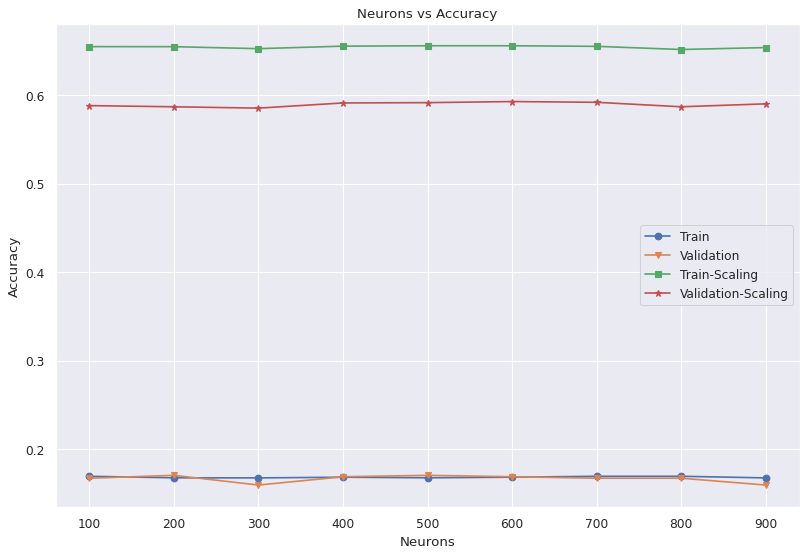

The best score with data validation:  0.170314282750752 with Neurons:  200
The best score with data validation with Scaling:  0.5925813632483065 with Neurons:  600


In [ ]:
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x,ytrain,'o-',label='Train')
plt.plot(x,yValidation,'v-',label='Validation')
plt.plot(x,ytrainScaler,'s-',label='Train-Scaling')
plt.plot(x,yValidationScaler,'*-',label='Validation-Scaling')

plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.title('Neurons vs Accuracy')
plt.legend()
plt.savefig('MLP-Algorithm.pdf', dpi=300)
plt.show()  
print('The best score with data validation: ', max(yValidation),'with Neurons: ',x[yValidation.index(max(yValidation))])
print('The best score with data validation with Scaling: ', max(yValidationScaler),'with Neurons: ',x[yValidationScaler.index(max(yValidationScaler))])

## MLP model with best value of hidden_layer_sizes

Accuracy: 0.584662775616083
F1 score: 0.5777970140135459
Recall: 0.584662775616083
Precision: 0.6085007953362341

 clasification report:
               precision    recall  f1-score   support

         1.0       0.60      0.89      0.71     20507
         2.0       0.81      0.39      0.53     20032
         3.0       0.62      0.50      0.55     20740
         4.0       0.58      0.56      0.57     21076
         5.0       0.45      0.53      0.49     20258
         6.0       0.59      0.64      0.61     20747

    accuracy                           0.58    123360
   macro avg       0.61      0.58      0.58    123360
weighted avg       0.61      0.58      0.58    123360


 confusion matrix:
 [[18198    22    71    82  1804   330]
 [ 1461  7835  1609  2308  3062  3757]
 [ 4630   586 10273   192  2383  2676]
 [ 1668   294   306 11809  5393  1606]
 [ 2659   437   729  4889 10752   792]
 [ 1895   463  3457   999   676 13257]]


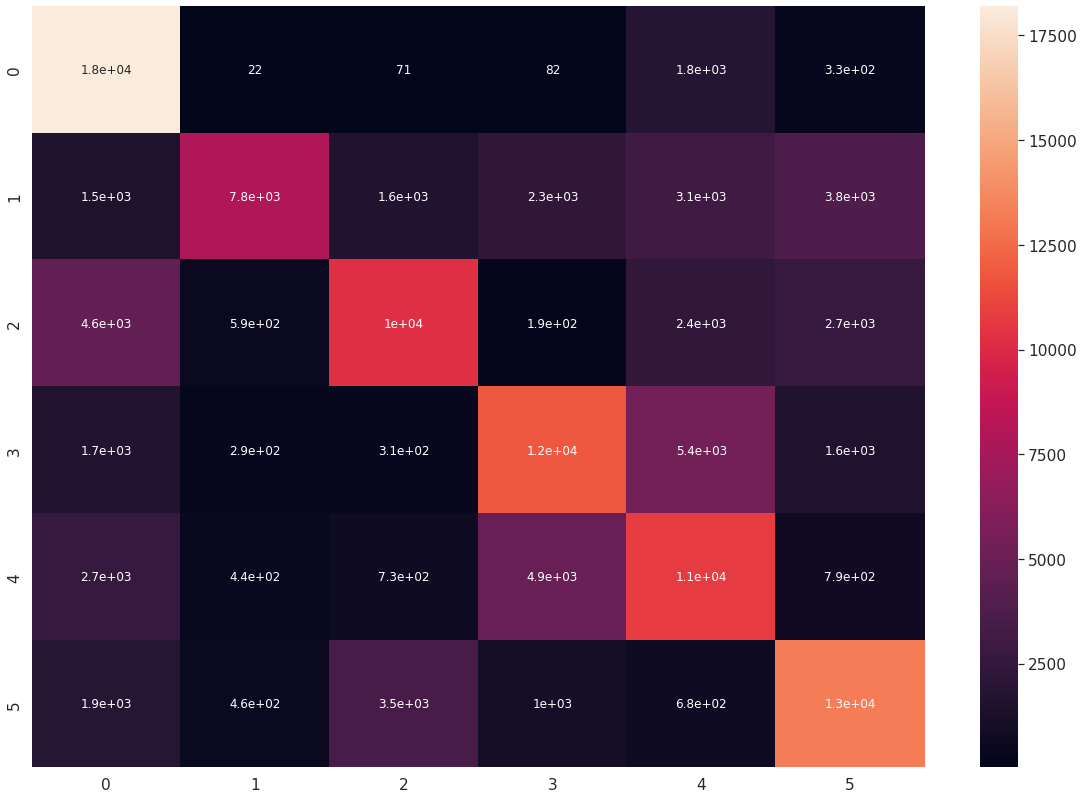

In [ ]:
MLP = MLPClassifier(solver='adam', alpha=.5, hidden_layer_sizes=x[yValidationScaler.index(max(yValidationScaler))])
MLP.fit(Features_train_scaler, Labels_train)
predictions = MLP.predict(Features_test_scaler)
metrics(Labels_test,predictions)

## Tuning Random forest model, n_estimators parameter

In [ ]:
#Testing different quantities of neighbors
limit=101
step=10
x=[x for x in range(1,limit,10)]
yValidation=[0 for x in range(1,limit,10)]
ytrain=[0 for x in range(1,limit,10)]
yValidationScaler=[0 for x in range(1,limit,10)]
ytrainScaler=[0 for x in range(1,limit,10)]
yValidationPCA=[0 for x in range(1,limit,10)]
ytrainPCA=[0 for x in range(1,limit,10)]
yValidationPCAScaler=[0 for x in range(1,limit,10)]
ytrainPCAScaler=[0 for x in range(1,limit,10)]
index=0
for i in range(10,limit,10):
    RF = RandomForestClassifier(n_estimators=i)
    
    RF.fit(Features_train, Labels_train)
    trainScore=RF.score(Features_train, Labels_train)
    validationScore=RF.score(Features_valid, Labels_valid)
    
    RF.fit(Features_train_scaler, Labels_train)
    trainScoreScaler=RF.score(Features_train_scaler, Labels_train)
    validationScoreScaler=RF.score(Features_valid_scaler, Labels_valid)
    
    print('n_estimators value:',i)
    ytrain[index]=trainScore   
    yValidation[index]=validationScore
    
    ytrainScaler[index]=trainScoreScaler   
    yValidationScaler[index]=validationScoreScaler
    
    index+=1

n_estimators value: 10
n_estimators value: 20
n_estimators value: 30
n_estimators value: 40
n_estimators value: 50
n_estimators value: 60
n_estimators value: 70
n_estimators value: 80
n_estimators value: 90
n_estimators value: 100


## Plotting n_estimators vs accuracy

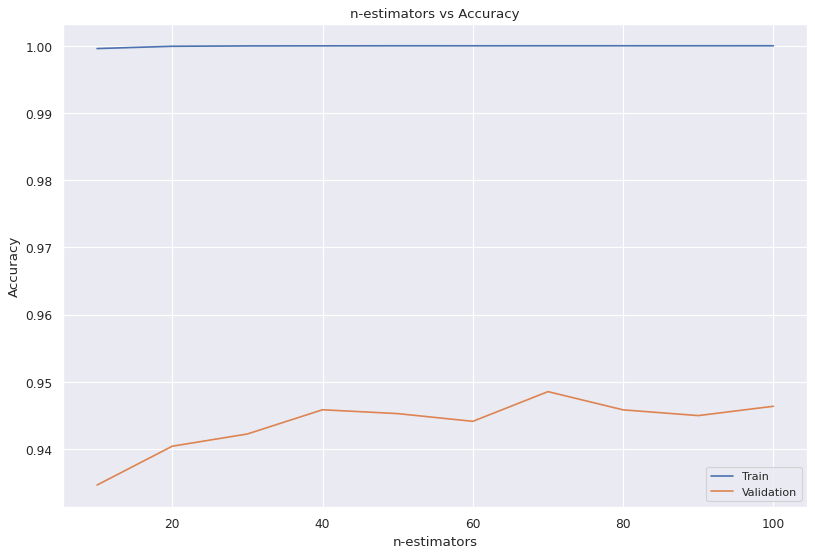

The best score with data validation:  0.9485291184285065 with estimators:  70


In [ ]:
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x,ytrain,label='Train')
plt.plot(x,yValidation,label='Validation')
#plt.plot(x,ytrainScaler,label='Train-Scaling')
#plt.plot(x,yValidationScaler,label='Validation-Scaling')

plt.xlabel('n-estimators')
plt.ylabel('Accuracy')
plt.title('n-estimators vs Accuracy')
plt.legend(fontsize=10)
plt.savefig('RF-Algorithm.pdf', dpi=300)
plt.show()  
print('The best score with data validation: ', max(yValidation),'with estimators: ',x[yValidation.index(max(yValidation))])
#print('The best score with data validation with Scaling: ', max(yValidationScaler),'with estimators: ',x[yValidationScaler.index(max(yValidationScaler))])

## Random Forest model with best n_estimators value

In [ ]:
Features_train_valid = np.concatenate((Features_train_scaler, Features_valid_scaler), axis=0)
Labels_train_valid = np.concatenate((Labels_train, Labels_valid), axis=0)

Accuracy: 0.9383916990920882
F1 score: 0.9383344777328713
Recall: 0.9383916990920882
Precision: 0.938974009252176

 clasification report:
               precision    recall  f1-score   support

         1.0       0.97      1.00      0.98     20507
         2.0       0.94      0.90      0.92     20032
         3.0       0.90      0.95      0.92     20740
         4.0       0.97      0.93      0.95     21076
         5.0       0.91      0.93      0.92     20258
         6.0       0.94      0.92      0.93     20747

    accuracy                           0.94    123360
   macro avg       0.94      0.94      0.94    123360
weighted avg       0.94      0.94      0.94    123360


 confusion matrix:
 [[20507     0     0     0     0     0]
 [  139 18063   634   179   553   464]
 [   60   392 19744    34    36   474]
 [   72   183    58 19611  1061    91]
 [  348   334   246   370 18796   164]
 [   12   229  1331    11   125 19039]]


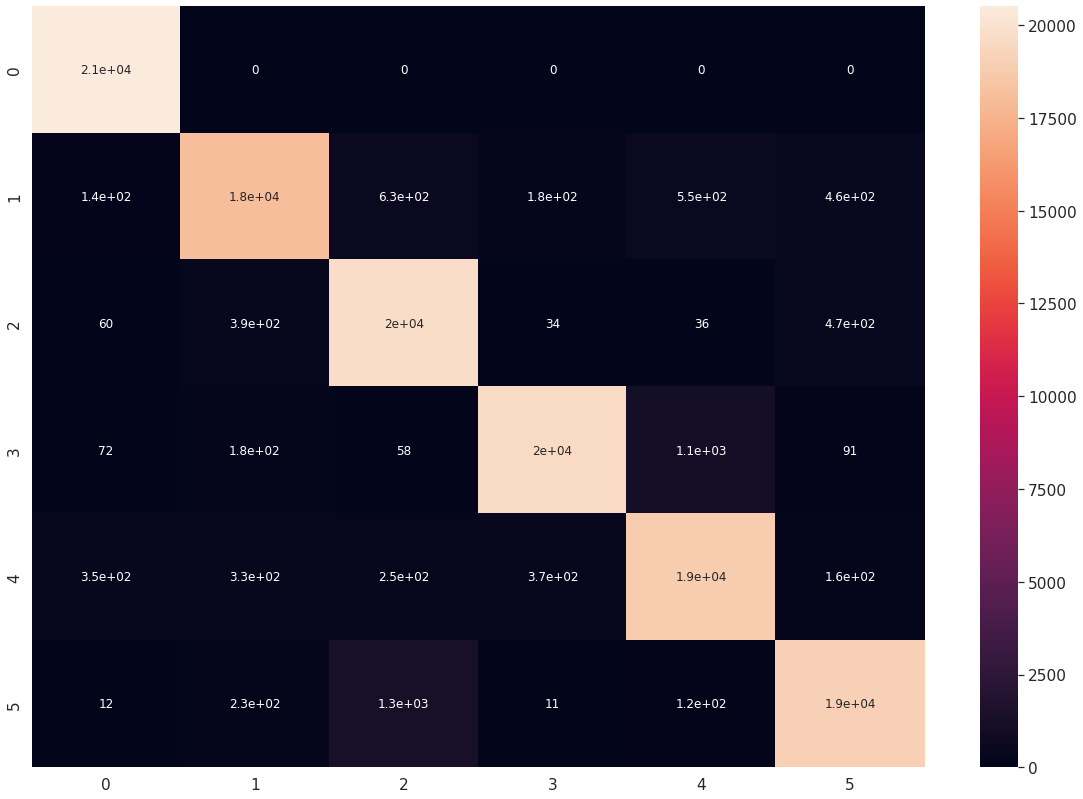

In [ ]:
RF = RandomForestClassifier(n_estimators=x[yValidationScaler.index(max(yValidationScaler))])
RF.fit(Features_train_valid, Labels_train_valid)
predictions = RF.predict(Features_test_scaler)
metrics(Labels_test,predictions)

## Decision Tree model

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(Features_train_scaler, Labels_train)
predictions = DT.predict(Features_test_scaler)
metrics(Labels_test,predictions)

## Cross validation of all models 

In [ ]:
def fold_creation(filenames, index):
    filenames_fold=[]
    filenames_fold.append(filenames[index[0]])
    filenames_fold.append(filenames[index[0]+1])
    filenames_fold.append(filenames[index[1]])
    filenames_fold.append(filenames[index[1]+1])
    filenames_fold.append(filenames[index[2]])
    filenames_fold.append(filenames[index[2]+1])
    filenames_fold.append(filenames[index[3]])
    filenames_fold.append(filenames[index[3]+1])

    [df1,df2,df3,df4,df5,df6]=Data_separation(filenames_fold[0])
    Gesto1=df1
    Gesto2=df2
    Gesto3=df3
    Gesto4=df4
    Gesto5=df5
    Gesto6=df6

    for i in range(len(filenames_fold[1:])):
        [df1,df2,df3,df4,df5,df6]=Data_separation(filenames[i])
        Gesto1=Gesto1.append(df1)
        Gesto2=Gesto2.append(df2)
        Gesto3=Gesto3.append(df3)
        Gesto4=Gesto4.append(df4)
        Gesto5=Gesto5.append(df5)
        Gesto6=Gesto6.append(df6)

    fold=Gesto1
    fold=fold.append(Gesto2)
    fold=fold.append(Gesto3)
    fold=fold.append(Gesto4)
    fold=fold.append(Gesto5)
    fold=fold.append(Gesto6)
    return fold

In [ ]:
pacientes = []
for i in range(0, 72, 2):
    pacientes.append(i)
index=np.random.choice(pacientes, (9, 4), replace=False)

In [ ]:
fold0=fold_creation(filenames, index[0])
fold1=fold_creation(filenames, index[1])
fold2=fold_creation(filenames, index[2])
fold3=fold_creation(filenames, index[3])
fold4=fold_creation(filenames, index[4])
fold5=fold_creation(filenames, index[5])
fold6=fold_creation(filenames, index[6])
fold7=fold_creation(filenames, index[7])
fold8=fold_creation(filenames, index[8])

In [ ]:
Labels_0 = fold0['class']
Features_0 = fold0[fold0.columns[0:8]]

Labels_1 = fold1['class']
Features_1 = fold1[fold1.columns[0:8]]

Labels_2 = fold2['class']
Features_2 = fold2[fold2.columns[0:8]]

Labels_3 = fold3['class']
Features_3 = fold3[fold3.columns[0:8]]

Labels_4 = fold4['class']
Features_4 = fold4[fold4.columns[0:8]]

Labels_5 = fold5['class']
Features_5 = fold5[fold5.columns[0:8]]

Labels_6 = fold6['class']
Features_6 = fold6[fold6.columns[0:8]]

Labels_7 = fold7['class']
Features_7 = fold7[fold7.columns[0:8]]

Labels_8 = fold8['class']
Features_8 = fold8[fold8.columns[0:8]]

In [ ]:
Features_full = Features_0.append(Features_1)
Features_full = Features_full.append(Features_2)
Features_full = Features_full.append(Features_3)
Features_full = Features_full.append(Features_4)
Features_full = Features_full.append(Features_5)
Features_full = Features_full.append(Features_6)
Features_full = Features_full.append(Features_7)
Features_full = Features_full.append(Features_8)

scaler = preprocessing.StandardScaler().fit(Features_full)
Features_fold0 = scaler.transform(Features_0)
Features_fold1 = scaler.transform(Features_1)
Features_fold2 = scaler.transform(Features_2)
Features_fold3 = scaler.transform(Features_3)
Features_fold4 = scaler.transform(Features_4)
Features_fold5 = scaler.transform(Features_5)
Features_fold6 = scaler.transform(Features_6)
Features_fold7 = scaler.transform(Features_7)
Features_fold8 = scaler.transform(Features_8)

In [ ]:
folds = [Features_fold0, Features_fold1, Features_fold2, Features_fold3, Features_fold4, Features_fold5, Features_fold6, Features_fold7, Features_fold8]
labels = [Labels_0, Labels_1, Labels_2, Labels_3, Labels_4, Labels_5, Labels_6, Labels_7, Labels_8]

In [ ]:
def manual_cross_val(model, folds, labels):
    Results = []
    index_t = [[0, 1, 2, 3, 4, 5, 6, 7], [8, 0, 1, 2, 3, 4, 5, 6], [7, 8, 0, 1, 2, 3, 4, 5], [6, 7, 8, 0, 1, 2, 3, 4], [5, 6, 7, 8, 0, 1, 2, 3]
            , [4, 5, 6, 7, 8, 0, 1, 2], [3, 4, 5, 6, 7, 8, 0, 1], [2, 3, 4, 5, 6, 7, 8, 0], [1, 2, 3, 4, 5, 6, 7, 8]]
    index_v = [8, 7, 6, 5, 4, 3 , 2, 1, 0]
    for i in range(len(index_t)):
      Train = folds[index_t[i][0]]
      Trainlabels = labels[index_t[i][0]]
      for j in range(len(index_t[i][1:])):
          Train = np.append(Train, folds[index_t[i][j]], axis=0)
          Trainlabels = np.append(Trainlabels, labels[index_t[i][j]], axis=0)
      Valid = folds[index_v[i]]
      Validlabels = labels[index_v[i]]
      model.fit(Train, Trainlabels)
      pred = model.predict(Valid)
      Results.append(accuracy_score(Validlabels, pred))
    return [np.mean(Results), np.std(Results)]

KNN = KNeighborsClassifier(n_neighbors=1)
lr = LogisticRegression(C=0.3)
NB = GaussianNB()
MLP = MLPClassifier(solver='adam', alpha=.5, hidden_layer_sizes=800)
RF = RandomForestClassifier(n_estimators=71)
DT = DecisionTreeClassifier()

In [ ]:
R_KNN = manual_cross_val(KNN, folds, labels)
print('KNN: ', R_KNN[0], R_KNN[1])
R_lr = manual_cross_val(lr, folds, labels)
print('LR: ', R_lr[0], R_lr[1])
R_NB = manual_cross_val(NB, folds, labels)
print('NB: ', R_NB[0], R_NB[1])
R_MLP = manual_cross_val(MLP, folds, labels)
print('MLP: ', R_MLP[0], R_MLP[1])
R_RF = manual_cross_val(RF, folds, labels)
print('RF: ', R_RF[0], R_RF[1])
R_DT = manual_cross_val(DT, folds, labels)
print('DT: ', R_DT[0], R_DT[1])

# Deep Learning using KERAS

## Tuning FNN

In [ ]:
encoder = LabelEncoder()
encoder.fit(Labels_train)
encoded_YTrain = encoder.transform(Labels_train)
encoded_YValidation = encoder.transform(Labels_valid)
encoded_YTest = encoder.transform(Labels_test)
encode_XTrain=Features_train_scaler
encode_Xvalidation=Features_valid_scaler
encode_Xtest=Features_test_scaler
# Convert integers to one hot labels
categorical_YTrain = np_utils.to_categorical(encoded_YTrain)
categorical_YValidation = np_utils.to_categorical(encoded_YValidation)
categorical_YTest = np_utils.to_categorical(encoded_YTest)

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(1000, input_dim=encode_XTrain.shape[1], activation='relu'))
    model.add(Dense(1000, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1000, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [ ]:
# How to Tune Batch Size and Number of Epochs

model = KerasClassifier(build_fn=create_model, verbose=1)
# define the grid search parameters
batch_size = [50000, 100000,150000]
epochs = [150, 170, 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# How to Tune the Training Optimization Algorithm

# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(1000, input_dim=encode_XTrain.shape[1], activation='relu'))
    model.add(Dense(1000, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1000, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=50000, verbose=1)
# define the grid search parameters
optimizer = ['RMSprop','Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=2)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
# How to Tune Network Weight Initialization

def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(1000,kernel_initializer=init_mode, input_dim=encode_XTrain.shape[1], activation='relu'))
    model.add(Dense(1000, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(1000, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(6, kernel_initializer=init_mode, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=50000, verbose=1)
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=2)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# How to Tune the Neuron Activation Function

def create_model(activation='relu'):
    # create model
    model = Sequential()
    model.add(Dense(1000,kernel_initializer='he_normal', input_dim=encode_XTrain.shape[1], activation=activation))
    model.add(Dense(1000, kernel_initializer='he_normal', activation=activation))
    model.add(Dense(1000, kernel_initializer='he_normal', activation=activation))
    model.add(Dense(6, kernel_initializer='he_normal', activation='softmax'))
    optimizer = SGD(lr=0.2, momentum=0)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=50000, verbose=1)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=2)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# How to Tune the Number of Neurons in the Hidden Layer

from keras.layers import Dropout
from keras.constraints import maxnorm

def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons,kernel_initializer='glorot_normal', input_dim=encode_XTrain.shape[1], activation='relu'))
    model.add(Dense(neurons, kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dense(neurons, kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='glorot_normal', activation='softmax'))
    optimizer = SGD(lr=0.2, momentum=0)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=50000, verbose=1)
# define the grid search parameters
neurons = [850, 900, 950, 1000, 1050, 1100, 1200]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Cross validation on ANN with best parameters

In [ ]:
def manual_cross_val_ANN(folds, labels):
    Results = []
    index_t = [[0, 1, 2, 3, 4, 5, 6, 7], [8, 0, 1, 2, 3, 4, 5, 6], [7, 8, 0, 1, 2, 3, 4, 5], [6, 7, 8, 0, 1, 2, 3, 4], [5, 6, 7, 8, 0, 1, 2, 3]
            , [4, 5, 6, 7, 8, 0, 1, 2], [3, 4, 5, 6, 7, 8, 0, 1], [2, 3, 4, 5, 6, 7, 8, 0], [1, 2, 3, 4, 5, 6, 7, 8]]
    index_v = [8, 7, 6, 5, 4, 3 , 2, 1, 0]
    for i in range(len(index_t)):
      encoder = LabelEncoder()
      Train = folds[index_t[i][0]]
      Trainlabels = labels[index_t[i][0]]
      for j in range(len(index_t[i][1:])):
          Train = np.append(Train, folds[index_t[i][j]], axis=0)
          Trainlabels = np.append(Trainlabels, labels[index_t[i][j]], axis=0)
      Valid = folds[index_v[i]]
      Validlabels = labels[index_v[i]]
      encoder.fit(Trainlabels)
      encoded_YTrain = encoder.transform(Trainlabels)
      encoded_YValidation = encoder.transform(Validlabels)
      encode_XTrain=Train #.reshape(Train.shape[0],Train.shape[1],1)
      encode_Xvalidation=Valid #.reshape(Valid.shape[0],Valid.shape[1],1)
      categorical_YTrain = np_utils.to_categorical(encoded_YTrain)
      categorical_YValidation = np_utils.to_categorical(encoded_YValidation)

      visible = Input(shape=(encode_XTrain.shape[1],))
      hidden1 = Dense(1050, kernel_initializer='normal', activation='tanh')(visible)
      hidden2 = Dense(1050, kernel_initializer='normal', activation='tanh')(hidden1)
      hidden3 = Dense(1050, kernel_initializer='normal', activation='tanh')(hidden2)
      hidden4 = Dense(1050, kernel_initializer='normal', activation='tanh')(hidden3)
      output = Dense(6, kernel_initializer='normal', activation='softmax')(hidden4)
      model = Model(inputs=visible, outputs=output)
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(lr=0.01), metrics=['accuracy'])
      model.fit(encode_XTrain, categorical_YTrain, epochs=150, batch_size=50000,verbose=0)
      snn_pred = model.predict(encode_Xvalidation, batch_size=50000, verbose=1)  
      snn_pred_lab = np.argmax(snn_pred, axis=1)
      snn_real_lab = np.argmax(categorical_YValidation, axis=1)
      Results.append(accuracy_score(snn_real_lab, snn_pred_lab))
    return [np.mean(Results), np.std(Results)]

R_ANN = manual_cross_val_ANN(folds, labels)
print('ANN: ', R_ANN[0], R_ANN[1])

## Training and testing FNN


In [ ]:
encoder = LabelEncoder()
encoder.fit(Labels_train)
encoded_YTrain = encoder.transform(Labels_train)
encoded_YValidation = encoder.transform(Labels_valid)
encoded_YTest = encoder.transform(Labels_test)
encode_XTrain=Features_train_scaler
encode_Xvalidation=Features_valid_scaler
encode_Xtest=Features_test_scaler
# Convert integers to one hot labels
categorical_YTrain = np_utils.to_categorical(encoded_YTrain)
categorical_YValidation = np_utils.to_categorical(encoded_YValidation)
categorical_YTest = np_utils.to_categorical(encoded_YTest)

visible = Input(shape=(encode_XTrain.shape[1],))
hidden1 = Dense(1050, kernel_initializer='normal', activation='tanh')(visible)
hidden2 = Dense(1050, kernel_initializer='normal', activation='tanh')(hidden1)
hidden3 = Dense(1050, kernel_initializer='normal', activation='tanh')(hidden2)
hidden4 = Dense(1050, kernel_initializer='normal', activation='tanh')(hidden3)
output = Dense(6, kernel_initializer='normal', activation='softmax')(hidden4)
model = Model(inputs=visible, outputs=output)
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(lr=0.01), metrics=['accuracy'])
# summarize layers
print(model.summary())
# Fit the model
history1=model.fit(encode_XTrain, categorical_YTrain, epochs=120, batch_size=50000, validation_data=(encode_Xvalidation, categorical_YValidation))

with plt.style.context('seaborn-white'):
  # plot metrics
  plt.plot(history1.history['accuracy'])
  plt.plot(history1.history['val_accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Model Accuracy')
  plt.legend(['train', 'validation'], loc='upper left', fontsize=10)
  plt.grid(True)
  plt.savefig('ACC_ANN.pdf', dpi=300)
  plt.show()

  plt.plot(history1.history['loss'])
  plt.plot(history1.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left', fontsize=10)
  plt.grid(True)
  plt.savefig('LOSS_ANN.pdf', dpi=300)
  plt.show()

scores = model.evaluate(encode_Xtest, categorical_YTest, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
snn_pred = model.predict(encode_Xtest, batch_size=50000, verbose=1)  
snn_predicted = np.argmax(snn_pred, axis=1)
snn_pred_lab = np.argmax(snn_pred, axis=1)
snn_real_lab = np.argmax(categorical_YTest, axis=1)
metrics(snn_real_lab,snn_pred_lab)

## Tuning CNN

In [ ]:
encoder = LabelEncoder()
encoder.fit(Labels_train)
encoded_YTrain = encoder.transform(Labels_train)
encoded_YValidation = encoder.transform(Labels_valid)
encoded_YTest = encoder.transform(Labels_test)
encode_XTrain=Features_train_scaler.reshape(Features_train_scaler.shape[0],Features_train_scaler.shape[1],1)
encode_Xvalidation=Features_valid_scaler.reshape(Features_valid_scaler.shape[0],Features_valid_scaler.shape[1],1)
encode_Xtest=Features_test_scaler.reshape(Features_test_scaler.shape[0],Features_test_scaler.shape[1],1)
# Convert integers to one hot labels
categorical_YTrain = np_utils.to_categorical(encoded_YTrain)
categorical_YValidation = np_utils.to_categorical(encoded_YValidation)
categorical_YTest = np_utils.to_categorical(encoded_YTest)

In [ ]:
# How to Tune the Training Optimization Algorithm

# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear', input_shape=(encode_XTrain.shape[1],1)))
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear'))
    model.add(keras.layers.Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(1050, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1050, activation='relu', kernel_initializer='normal'))
    model.add(Dense(6,activation='softmax', kernel_initializer='normal'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=15000, verbose=1)
# define the grid search parameters
optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# How to Tune Learning Rate and Momentum
def create_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=(3), activation='relu', input_shape=(encode_XTrain.shape[1],1)))
    model.add(Conv1D(filters=32, kernel_size=(3), activation='relu'))
    model.add(MaxPooling1D(1))
    model.add(Conv1D(filters=32, kernel_size=(3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='softsign'))
    model.add(Dense(6,activation='softmax'))
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=1)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear', input_shape=(encode_XTrain.shape[1],1)))
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear'))
    model.add(keras.layers.Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(1050, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1050, activation='relu', kernel_initializer='normal'))
    model.add(Dense(6,activation='softmax', kernel_initializer='normal'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# How to Tune Batch Size and Number of Epochs

model = KerasClassifier(build_fn=create_model, epochs=150, verbose=1)
# define the grid search parameters
batch_size = [10000, 15000, 20000, 30000, 50000]
param_grid = dict(batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# How to Tune Network Weight Initialization

def create_model(init_mode='uniform'):
    # create model
    # create model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear', input_shape=(encode_XTrain.shape[1],1)))
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear'))
    model.add(keras.layers.Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(1050, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1050, activation='relu', kernel_initializer='normal'))
    model.add(Dense(6,activation='softmax', kernel_initializer='normal'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10000, verbose=1)
init_mode = ['uniform', 'normal', 'glorot_normal', 'he_normal']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# How to Tune the Neuron Activation Function

def create_model(activation='relu'):
    # create model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear', input_shape=(encode_XTrain.shape[1],1)))
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear'))
    model.add(keras.layers.Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(1050, activation=activation, kernel_initializer='normal'))
    model.add(Dense(1050, activation=activation, kernel_initializer='normal'))
    model.add(Dense(6,activation='softmax', kernel_initializer='normal'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10000, verbose=1)
# define the grid search parameters
activation = ['relu', 'tanh', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# How to Tune Dropout Regularization
def create_model(dropout_rate=0.0, weight_constraint=0):
    # create model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear', input_shape=(encode_XTrain.shape[1],1)))
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear'))
    model.add(keras.layers.Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(1050, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(1050, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(6,activation='softmax', kernel_initializer='normal'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10000, verbose=1)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
# How to Tune the Number of Neurons in the Hidden Layer
def create_model(neurons=1050):
    # create model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear', input_shape=(encode_XTrain.shape[1],1)))
    model.add(Conv1D(filters=32, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear'))
    model.add(keras.layers.Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(neurons, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(neurons, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(6,activation='softmax', kernel_initializer='normal'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10000, verbose=1)
# define the grid search parameters
neurons = [1050, 1100, 1200, 1300]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=2)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# How to Tune the Number of filters 
def create_model(filters=32, kernel_size=3):
    # create model
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size,kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear', input_shape=(encode_XTrain.shape[1],1)))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size,kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear'))
    model.add(keras.layers.Activation('relu'))
    #model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(1300, activation='tanh', kernel_initializer='normal', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1300, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(600, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(6,activation='softmax', kernel_initializer='normal'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10000, verbose=0)
# define the grid search parameters
filters = [16, 32, 64, 128]
kernel_size = [1, 2, 3]
param_grid = dict(filters=filters, kernel_size=kernel_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=2)
grid_result = grid.fit(encode_XTrain, categorical_YTrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Cross validation on CNN with best parameters

In [ ]:
from sklearn.metrics import accuracy_score

def manual_cross_val_CNN(folds, labels):
    Results = []
    index_t = [[0, 1, 2, 3, 4, 5, 6, 7], [8, 0, 1, 2, 3, 4, 5, 6], [7, 8, 0, 1, 2, 3, 4, 5], [6, 7, 8, 0, 1, 2, 3, 4], [5, 6, 7, 8, 0, 1, 2, 3]
            , [4, 5, 6, 7, 8, 0, 1, 2], [3, 4, 5, 6, 7, 8, 0, 1], [2, 3, 4, 5, 6, 7, 8, 0], [1, 2, 3, 4, 5, 6, 7, 8]]
    index_v = [8, 7, 6, 5, 4, 3 , 2, 1, 0]
    for i in range(len(index_t)):
      encoder = LabelEncoder()
      Train = folds[index_t[i][0]]
      Trainlabels = labels[index_t[i][0]]
      for j in range(len(index_t[i][1:])):
          Train = np.append(Train, folds[index_t[i][j]], axis=0)
          Trainlabels = np.append(Trainlabels, labels[index_t[i][j]], axis=0)
      Valid = folds[index_v[i]]
      Validlabels = labels[index_v[i]]
      encoder.fit(Trainlabels)
      encoded_YTrain = encoder.transform(Trainlabels)
      encoded_YValidation = encoder.transform(Validlabels)
      encode_XTrain=Train.reshape(Train.shape[0],Train.shape[1],1)
      encode_Xvalidation=Valid.reshape(Valid.shape[0],Valid.shape[1],1)
      categorical_YTrain = np_utils.to_categorical(encoded_YTrain)
      categorical_YValidation = np_utils.to_categorical(encoded_YValidation)

      CNN = Sequential()
      CNN.add(Conv1D(filters=128, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear', input_shape=(encode_XTrain.shape[1],1)))
      CNN.add(Conv1D(filters=128, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear'))
      CNN.add(keras.layers.Activation('relu'))
      CNN.add(Flatten())
      CNN.add(Dense(1300, activation='tanh', kernel_initializer='normal', kernel_regularizer=keras.regularizers.l2(0.001)))
      CNN.add(Dense(1300, activation='tanh', kernel_initializer='normal'))
      CNN.add(Dense(600, activation='tanh', kernel_initializer='normal'))
      CNN.add(Dense(6,activation='softmax', kernel_initializer='normal'))
      optimizer = keras.optimizers.Nadam(lr=0.001)
      # Compile model
      CNN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
      CNN.fit(encode_XTrain, categorical_YTrain, epochs=100, batch_size=10000, verbose=0)
      snn_pred = CNN.predict(encode_Xvalidation, batch_size=10000, verbose=1)  
      snn_pred_lab = np.argmax(snn_pred, axis=1)
      snn_real_lab = np.argmax(categorical_YValidation, axis=1)
      Results.append(accuracy_score(snn_real_lab, snn_pred_lab))
    return [np.mean(Results), np.std(Results)]


R_CNN = manual_cross_val_CNN(folds, labels)
print('CNN: ', R_CNN[0], R_CNN[1])

## Training and Testing CNN

In [ ]:
encoder = LabelEncoder()
encoder.fit(Labels_train)
encoded_YTrain = encoder.transform(Labels_train)
encoded_YValidation = encoder.transform(Labels_valid)
encoded_YTest = encoder.transform(Labels_test)
encode_XTrain=Features_train_scaler.reshape(Features_train_scaler.shape[0],Features_train_scaler.shape[1],1)
encode_Xvalidation=Features_valid_scaler.reshape(Features_valid_scaler.shape[0],Features_valid_scaler.shape[1],1)
encode_Xtest=Features_test_scaler.reshape(Features_test_scaler.shape[0],Features_test_scaler.shape[1],1)
# Convert integers to one hot labels
categorical_YTrain = np_utils.to_categorical(encoded_YTrain)
categorical_YValidation = np_utils.to_categorical(encoded_YValidation)
categorical_YTest = np_utils.to_categorical(encoded_YTest)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear', input_shape=(encode_XTrain.shape[1],1)))
model.add(Conv1D(filters=128, kernel_size=(3),kernel_constraint=maxnorm(1), kernel_initializer='normal', activation='linear'))
model.add(keras.layers.Activation('relu'))
model.add(Flatten())
model.add(Dense(1300, activation='tanh', kernel_initializer='normal', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dense(1300, activation='tanh', kernel_initializer='normal'))
model.add(Dense(600, activation='tanh', kernel_initializer='normal'))
model.add(Dense(6,activation='softmax', kernel_initializer='normal'))
optimizer = keras.optimizers.Nadam(lr=0.001)
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

print(model.summary())

history=model.fit(encode_XTrain, categorical_YTrain, epochs=120, batch_size=10000, validation_data=(encode_Xvalidation, categorical_YValidation))

with plt.style.context('seaborn-white'):
  # plot metrics
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Model Accuracy')
  plt.legend(['train', 'validation'], loc='upper left', fontsize=10)
  plt.grid(True)
  plt.savefig('ACC_CNN.pdf', dpi=300)
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left', fontsize=10)
  plt.grid(True)
  plt.savefig('LOSS_CNN.pdf', dpi=300)
  plt.show()


In [ ]:
snn_pred = model.predict(encode_Xtest, batch_size=10000, verbose=1)  
snn_pred_lab = np.argmax(snn_pred, axis=1)
snn_real_lab = np.argmax(categorical_YTest, axis=1)
metrics(snn_real_lab, snn_pred_lab)